# N-Gram

## 数据处理

In [6]:
import codecs
import jieba
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

In [7]:
class DataUtils:
    def __init__(self, path):
        self.path = path

    # 读取邮件信息
    def read_dataset(self):
        with open(self.path + "/ham_5000.utf8", encoding='utf-8') as f:
            ham_txt_list = f.readlines()
        with open(self.path + "/spam_5000.utf8", encoding='utf-8') as f:
            spam_txt_list = f.readlines()
        stopwords_list = codecs.open(
            self.path + "/stopword.txt", 'r', 'utf8').read().split('\r\n')
        return ham_txt_list, spam_txt_list, stopwords_list

    # 去除停用词
    def wipe_stop_words(self, mails, stop_words):
        new_mails = []
        for mail in mails:
            seg_words = jieba.cut(mail)
            new_mail_list = []
            for words in seg_words:
                if words != '\n' and words not in stop_words:
                    new_mail_list.append(words)
            new_mail = " ".join(new_mail_list)

            new_mail = "<s> " + new_mail + " </s>"
            new_mails.append(new_mail)
        return new_mails

    def transformerTextToMatrix(self, texts):
        vectorizers = CountVectorizer(binary=False)
        vectorizers.fit(texts)

        # countVector 默认排序表是按照key的大小给出
        vector = vectorizers.transform(texts)
        result = pd.DataFrame(vector.toarray())
        result.columns = vectorizers.get_feature_names()
        return result

    def split_dataset(self, data, label):
        """送进去什么类型，返回的还是什么类型，dataFrame返回DataFrame,list返回list"""
        X_train, X_test, y_train, y_test = train_test_split(
            data, label, train_size=0.8, random_state=3)
        return X_train, X_test, y_train, y_test

    def data_preprocessing(self):
        hams, spams, stop_words = self.read_dataset()
        preprocess_hams = self.wipe_stop_words(hams, stop_words)
        preprocess_spams = self.wipe_stop_words(spams, stop_words)
        whole_text = preprocess_hams.copy()
        for spam in preprocess_spams:
            whole_text.append(spam)
        whole_label = [0] * len(preprocess_hams) + [1] * len(preprocess_spams)
        return whole_text, whole_label

    def extracted_count_feature(self, pdFeatures, count, islog=True):
        """
             去除特征出现次数较少的数据
        :param pd: type:Dataframe:包含feature
        :param count: type:int: feature出现的频率，大于该值才会作为用于训练特征
        :return:type:DataFrame with extracted_features
        """
        # Note:dataFrame默认求和
        sumFeatures = pd.DataFrame(pdFeatures.apply(sum, axis=0))
        print(sumFeatures.iloc[0], "--", sumFeatures.iloc[0, 0])
        extractedFeature_cols = [sumFeatures.index[i] for i in range(len(pdFeatures.columns))
                                 if sumFeatures.iloc[i, 0] > count]

        pdExtractedFeature = pdFeatures[extractedFeature_cols]

        if islog:
            print(len(pdExtractedFeature.columns), len(pdFeatures.columns))
        return pdExtractedFeature

    def extracted_correlation_feature(self, pdFeatures, label, lower_cor=1e-2, islog=False):
        """
             去除和标签关联度较低的特征

        :param pdFeatures: type:Dataframe:包含feature
        :param label: type:List:包含label
        :param lower_cor: type:float: feature和label的关联程度
        :param islog: print log
        :return:type:DataFrame with extracted_features
        """
        selected_feature = []
        for i in pdFeatures.columns:
            x = np.array(pdFeatures[i])
            y = np.abs(np.corrcoef(x, np.array(label))[0][1])
            if islog:
                print("y cor with ", i, " ", y)
            if y > lower_cor:
                selected_feature.append(i)
        if islog:
            print("select features before", len(pdFeatures.columns))
            print("select features by corr", len(selected_feature))
        return pdFeatures[selected_feature]

## 构建模型
模型架构：  
![](./imgs/n-gram.png)  
稀疏性问题:  
![](./imgs/sparty.png)

In [101]:
class NGram:
    def __init__(self, n_grams=2, smooth_k=1):
        self.n_grams = n_grams
        self.gram_map = {}
        self.term_map = {}
        self.smooth_k = smooth_k
        self.v = 0

    def generate_for_sentence(self, sentence):
        """

        :param sentence: type:list data for sentence
        :param n: n-gram,default:2
        :return: None
        """

        length = len(sentence)

        for i in range(length):
            # 构建 term gram统计表
            if i < length + 1 - self.n_grams:
                # 分母
                word = sentence[i:i + self.n_grams - 1]
                if word not in self.term_map.keys():
                    self.term_map[word] = 1
                else:
                    self.term_map[word] = self.term_map[word] + 1
                # 分子
                gram = sentence[i:i+self.n_grams]
                if gram not in self.gram_map.keys():
                    self.gram_map[gram] = 1
                else:
                    self.gram_map[gram] = self.gram_map[gram] + 1

    def generate_for_doc(self, documents):
        for document in documents:
            self.generate_for_sentence(document)
        self.v = len(self.term_map)

    def cal_posterior_prob(self, wordA, wordCombine):
        # 防止稀疏性，做平滑处理
        # 其中V是语料库中词语集合的长度。k是超参数，需要根据需要自主调节。
        word_freq = self.smooth_k * self.v
        gram_freq = self.smooth_k

        if wordA in self.term_map.keys():
            word_freq += self.term_map[wordA]

        if wordCombine in self.gram_map.keys():
            gram_freq += self.gram_map[wordCombine]

        return gram_freq/word_freq + 1e-5


class NGramModel:
    def __init__(self, data, label, n_grams=2, smooth_k=1, islog=True):
        """

        :param data:  type:list, two dims: input data,each row is a document
        :param label: type:list label, responding to label info
        :param n_grams: type:int
        :param smooth_k: type:int
        """
        self.data = data
        self.label = label
        self.n_grams = n_grams
        self.smooth_k = smooth_k
        self.NGram_list = []
        self.uniqueLabel = np.unique(label).tolist()
        for i in self.uniqueLabel:
            # 1为广告 0为邮件
            tGram = NGram(self.n_grams, self.smooth_k)
            tGram.generate_for_doc(np.array(data)[np.array(label) == i])
            if islog:
                print("总数据长度:", len(data), "label为", i, "长度",
                      len(np.array(data)[np.array(label) == i]))
                print("词汇表长度:", tGram.v)
            self.NGram_list.append(tGram)

    def predict(self, documents):
        """
        :param documents: type:list
        :return label: type:list label info
        """
        documentProb = []
        documentsProb = []
        for document in documents:
            for label in self.uniqueLabel:
                probL = self.predictLog(document, label)
                documentProb.append(probL)
            documentsProb.append(documentProb)
            documentProb = []
        return np.array(self.uniqueLabel)[np.argmax(documentsProb, axis=1)].tolist()

    def predictLog(self, document, label):
        documentLen = len(document)
        logProb = 0.0
        for i in range(documentLen - self.n_grams + 1):
            prob = self.NGram_list[self.uniqueLabel.index(label)].cal_posterior_prob(
                document[i:i+self.n_grams-1], document[i:i+self.n_grams])
            logProb = logProb + np.log(prob)
        return logProb

## 训练模型

In [102]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [104]:
if __name__ == '__main__':
    datapath = 'data'
    utils = DataUtils(datapath)
    whole_text, whole_label = utils.data_preprocessing()

    # 数据划分，80%训练，20%验证
    XTrain, XTest, YTrain, YTest = train_test_split(
        whole_text, whole_label, train_size=0.8, random_state=3)

    print("train len", len(XTrain), "test len", len(XTest))

    # 针对构造的N_gram对测试集进行概率预测，预测邮件究竟属于常规邮件的概率更大还是垃圾邮件的概率更大。
    n_grams_list = [1, 2, 3, 4, 5, 6, 7]
    smooth_k_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
    for n_gram in n_grams_list:
        for smooth_k in smooth_k_list:
            model = NGramModel(XTrain, YTrain, n_grams=n_gram,
                               smooth_k=smooth_k, islog=False)
            testRes = model.predict(XTest)
            print("grams:", n_gram, "smooth:", smooth_k, "acc:", sum(
                np.array(testRes) == np.array(YTest)) / (len(testRes) + 0.0))

train len 8000 test len 2001
grams: 1 smooth: 1e-06 acc: 0.9450274862568716
grams: 1 smooth: 1e-05 acc: 0.9450274862568716
grams: 1 smooth: 0.0001 acc: 0.9450274862568716
grams: 1 smooth: 0.001 acc: 0.9450274862568716
grams: 1 smooth: 0.01 acc: 0.9450274862568716
grams: 1 smooth: 0.1 acc: 0.9450274862568716
grams: 1 smooth: 1.0 acc: 0.9455272363818091
grams: 2 smooth: 1e-06 acc: 0.9905047476261869
grams: 2 smooth: 1e-05 acc: 0.9905047476261869
grams: 2 smooth: 0.0001 acc: 0.9905047476261869
grams: 2 smooth: 0.001 acc: 0.9905047476261869
grams: 2 smooth: 0.01 acc: 0.9905047476261869
grams: 2 smooth: 0.1 acc: 0.9890054972513743
grams: 2 smooth: 1.0 acc: 0.9775112443778111
grams: 3 smooth: 1e-06 acc: 0.9870064967516242
grams: 3 smooth: 1e-05 acc: 0.9870064967516242
grams: 3 smooth: 0.0001 acc: 0.9875062468765617
grams: 3 smooth: 0.001 acc: 0.9880059970014993
grams: 3 smooth: 0.01 acc: 0.9930034982508745
grams: 3 smooth: 0.1 acc: 0.991504247876062
grams: 3 smooth: 1.0 acc: 0.96151924037981

## 可视化

0.9365
0.9865
0.9895
0.995
0.988
0.9615


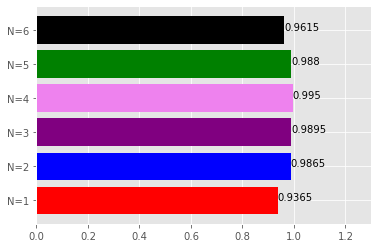

In [105]:
import matplotlib.pyplot as plt

x = ["N=1", "N=2", "N=3", "N=4", "N=5", "N=6"]
y = [0.9365, 0.9865, 0.9895, 0.9950, 0.9880, 0.9615]
rects = plt.barh(x, y, color=["red", "blue",
                              "purple", "violet", "green", "black"])
for rect in rects:  # rects 是三根柱子的集合
    width = rect.get_width()
    print(width)
    plt.text(width, rect.get_y() + rect.get_height() / 2, str(width), size=10)
plt.xlim(0.0, 1.3)
# plt.legend()
plt.show()

0.9895
0.99
0.995
0.9885
0.974
0.831


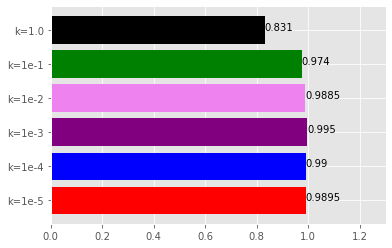

In [106]:
x = ["k=1e-5", "k=1e-4", "k=1e-3", "k=1e-2", "k=1e-1", "k=1.0"]
y = [0.9895, 0.9900, 0.9950, 0.9885, 0.9740, 0.831]
# y = [0.9365, 0.9865, 0.9895, 0.9950,0.9880,0.9615]
rects = plt.barh(x, y, color=["red", "blue",
                              "purple", "violet", "green", "black"])
for rect in rects:  # rects 是三根柱子的集合
    width = rect.get_width()
    print(width)
    plt.text(width, rect.get_y() + rect.get_height() / 2, str(width), size=10)
plt.xlim(0.0, 1.3)
# plt.legend()
plt.show()

# 参考
[N-gram-based text categorization](https://www.semanticscholar.org/paper/N-gram-based-text-categorization-Cavnar-Trenkle/49af572ef8f7ea89db06d5e7b66e9369c22d7607)  
[N-Gram代码](https://github.com/FindTheTruth/Natural-Language-Processing/tree/main/N-Gram)  
[NLP文本表示：N-Gram](https://mp.weixin.qq.com/s?src=11&timestamp=1649205497&ver=3721&signature=JFvicwCS0UJ9HjavsLpMoFyNRvD7r485xCPdL5QDgT9ccSz9ZGRRyxfPk6ssimSUgGyBdKUGMUB6GNlY4K43IRPJPuKaytAC*RugYwSusgAC380qYt4GD7UGu7DphU8s&new=1)